# Семантическая сегментация

**Семантическая сегментация (Semantic Segmentation)** - это по сути задача **пиксельной классификации**, когда для каждого пикселя изображения необходимо указать его класс (включая фон). Семантическая сегментация сообщает только пиксельный класс, более продвинутые алгоритма, находящие экземпляры объектов, называются **Instance Segmentation**. 

Почти все архитектуры сегментации имеют одинаковую структуру. Первая часть - это **кодировщик**, который извлекает признаки из входного изображения, вторая часть - **декодер**, который преобразует эти признаки обратно в изображение с той же высотой и шириной и некоторым количеством каналов, которое равно количеству классов. Для каждого пикселя исходного изображения мы получаем на выходе вероятность его принадлежности к тому или иному классу.

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as keras
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import os
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
train_size = 0.8
lr = 3e-4
weight_decay = 8e-9
batch_size = 64
epochs = 100

## Датасет

Используем [датасет фотографий родинок](https://www.kaggle.com/datasets/kanametov/ph2dataset) на теле человека c Kaggle.

![](https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/lessons/4-ComputerVision/12-Segmentation/images/navi.png)

 Мы загрузим слегка модифицированную его версию:

In [ ]:
!wget http://www.soshnikov.com/permanent/data/PH2Dataset.rar
!unrar x -Y PH2Dataset.rar

In [18]:
def load_dataset(train_part, root='PH2Dataset'):
    images = []
    masks = []

    for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
        if root.endswith('_Dermoscopic_Image'):
            images.append(imread(os.path.join(root, files[0])))
        if root.endswith('_lesion'):
            masks.append(imread(os.path.join(root, files[0])))

    size = (256, 256)
    images = np.array([resize(image, size, mode='constant', anti_aliasing=True,) for image in images])
    masks = np.expand_dims(np.array([resize(mask, size, mode='constant', anti_aliasing=False) > 0.5 for mask in masks]), axis=3)

    indices = np.random.permutation(range(len(images)))
    train_part = int(train_part * len(images))
    train_ind = indices[:train_part]
    test_ind = indices[train_part:]

    X_train = tf.cast(images[train_ind, :, :, :], tf.float32)
    y_train = tf.cast(masks[train_ind, :, :, :], tf.float32)

    X_test = tf.cast(images[test_ind, :, :, :], tf.float32)
    y_test = tf.cast(masks[test_ind, :, :, :], tf.float32)

    return (X_train, y_train), (X_test, y_test)

In [19]:
(X_train, y_train), (X_test, y_test) = load_dataset(train_size)

In [20]:
X_train.shape, y_train.shape

(TensorShape([160, 256, 256, 3]), TensorShape([160, 256, 256, 1]))

In [21]:
def plotn(n, data):
    images, masks = data[0], data[1]
    fig, ax = plt.subplots(1, n)
    fig1, ax1 = plt.subplots(1, n)
    for i, (img, mask) in enumerate(zip(images, masks)):
        if i == n:
            break
        ax[i].imshow(img)
        ax1[i].imshow(mask[:, :, 0])
    plt.show()

Посмотрим на изображения из датасета:

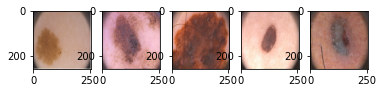

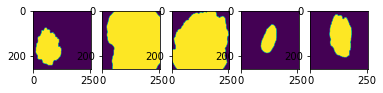

In [22]:
plotn(5, (X_train, y_train))

## SegNet

SegNet - это самая простая архитектура энкодера-декодера, в которой CNN-энкодер сначала переводит изображение в вектор признаков, а затем по нему восстанавливает маску.

<img src="./images/segnet.png" width="80%">

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)


In [ ]:
class SegNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = keras.Conv2D(16, kernel_size=3, padding='same')
        self.bn0 = keras.BatchNormalization()
        self.pool0 = keras.MaxPool2D()

        self.enc_conv1 = keras.Conv2D(32, kernel_size=3, padding='same')
        self.bn1 = keras.BatchNormalization()
        self.pool1 = keras.MaxPool2D()

        self.enc_conv2 = keras.Conv2D(64, kernel_size=3, padding='same')
        self.bn2 = keras.BatchNormalization()
        self.pool2 = keras.MaxPool2D()

        self.enc_conv3 = keras.Conv2D(128, kernel_size=3, padding='same')
        self.bn3 = keras.BatchNormalization()
        self.pool3 = keras.MaxPool2D()

        self.bottleneck_conv = keras.Conv2D(256, kernel_size=(3, 3), padding='same')

        self.upsample0 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv0 = keras.Conv2D(128, kernel_size=3, padding='same')
        self.dec_bn0 = keras.BatchNormalization()

        self.upsample1 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv1 = keras.Conv2D(64, kernel_size=3, padding='same')
        self.dec_bn1 = keras.BatchNormalization()

        self.upsample2 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv2 = keras.Conv2D(32, kernel_size=3, padding='same')
        self.dec_relu2 = keras.Activation('relu')
        self.dec_bn2 = keras.BatchNormalization()

        self.upsample3 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv3 = keras.Conv2D(1, kernel_size=1)

    def call(self, input):
        e0 = self.pool0(tf.nn.relu(self.bn0(self.enc_conv0(input))))
        e1 = self.pool1(tf.nn.relu(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(tf.nn.relu(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(tf.nn.relu(self.bn3(self.enc_conv3(e2))))

        b = self.bottleneck_conv(e3)

        d0 = tf.nn.relu(self.dec_bn0(self.upsample0(self.dec_conv0(b))))
        d1 = tf.nn.relu(self.dec_bn1(self.upsample1(self.dec_conv1(d0))))
        d2 = tf.nn.relu(self.dec_bn2(self.upsample2(self.dec_conv2(d1))))
        d3 = self.dec_conv3(self.upsample3(d2))

        return d3

In [25]:
model = SegNet()
optimizer = optimizers.Adam(learning_rate=lr, decay=weight_decay)
loss_fn = losses.BinaryCrossentropy(from_logits=True)

model.compile(loss=loss_fn, optimizer=optimizer)

In [28]:
hist = model.fit(X_train, y_train,
                epochs=30,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, y_test))

Epoch 1/30
3/3 [==============================] - 1s 262ms/step - loss: 0.0577 - val_loss: 0.4028
Epoch 2/30
3/3 [==============================] - 1s 240ms/step - loss: 0.0578 - val_loss: 0.4238
Epoch 3/30
3/3 [==============================] - 1s 194ms/step - loss: 0.0554 - val_loss: 0.4070
Epoch 4/30
3/3 [==============================] - 1s 196ms/step - loss: 0.0553 - val_loss: 0.4162
Epoch 5/30
3/3 [==============================] - 1s 194ms/step - loss: 0.0555 - val_loss: 0.3997
Epoch 6/30
3/3 [==============================] - 1s 194ms/step - loss: 0.0542 - val_loss: 0.3847
Epoch 7/30
3/3 [==============================] - 1s 196ms/step - loss: 0.0560 - val_loss: 0.3629
Epoch 8/30
3/3 [==============================] - 1s 199ms/step - loss: 0.0520 - val_loss: 0.3761
Epoch 9/30
3/3 [==============================] - 1s 194ms/step - loss: 0.0543 - val_loss: 0.3601
Epoch 10/30
3/3 [==============================] - 1s 197ms/step - loss: 0.0546 - val_loss: 0.3460
Epoch 11/30
3/3 [==

1/1 [==============================] - 0s 17ms/step


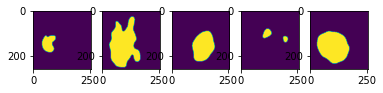

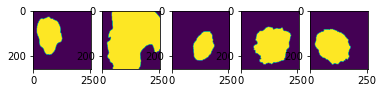

In [29]:
predictions = []
image_mask = []
plots = 5

for i, (img, mask) in enumerate(zip(X_test, y_test)):
    if i == plots:
        break
    img = tf.expand_dims(img, 0)
    pred = np.array(model.predict(img))
    predictions.append(pred[0, :, :, 0] > 0.5)
    image_mask.append(mask)
plotn(plots, (predictions, image_mask))

## U-Net

Основная проблема SegNet в том, что, переходя к вектору признаков, мы теряем в точности пространственной информации. Например, в VGG-16, исходное изображение 224x224 преобразуется к тензору 7x7x512, у которого всего лишь 7x7 пространственных измерений, по который в дальнейшем надо восстановить маску. Отчасти проблема решается в SegNet наличием Pooling Indices, а отчасти тем, что фильтры CNN способны "помнить форму".

Однако улучшить сегментацию позволяет подход, при котором на каждом уровне деконволюции мы используем не только информацию с предыдушего уровня, но и информацию с энкодера соответствующего слоя. Такое использование достигается простой конкатенацией тензоров признаков по размерности фильтров (пространственные размерности при этом совпадают).

В реализации "взрослого" U-Net обычно используют предобученные CNN для энкодера, например, ResNet-50.

<img src="images/unet.png" width="70%">

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. [U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)


In [32]:
class UNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = keras.Conv2D(16, kernel_size=3, padding='same')
        self.bn0 = keras.BatchNormalization()
        self.pool0 = keras.MaxPool2D()

        self.enc_conv1 = keras.Conv2D(32, kernel_size=3, padding='same')
        self.bn1 = keras.BatchNormalization()
        self.pool1 = keras.MaxPool2D()

        self.enc_conv2 = keras.Conv2D(64, kernel_size=3, padding='same')
        self.bn2 = keras.BatchNormalization()
        self.pool2 = keras.MaxPool2D()

        self.enc_conv3 = keras.Conv2D(128, kernel_size=3, padding='same')
        self.bn3 = keras.BatchNormalization()
        self.pool3 = keras.MaxPool2D()

        self.bottleneck_conv = keras.Conv2D(256, kernel_size=(3, 3), padding='same')

        self.upsample0 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv0 = keras.Conv2D(128, kernel_size=3, padding='same', input_shape=[None, 384, None, None])
        self.dec_bn0 = keras.BatchNormalization()

        self.upsample1 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv1 = keras.Conv2D(64, kernel_size=3, padding='same', input_shape=[None, 192, None, None])
        self.dec_bn1 = keras.BatchNormalization()

        self.upsample2 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv2 = keras.Conv2D(32, kernel_size=3, padding='same', input_shape=[None, 96, None, None])
        self.dec_bn2 = keras.BatchNormalization()

        self.upsample3 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv3 = keras.Conv2D(1, kernel_size=1, input_shape=[None, 48, None, None])

    def call(self, input):
        cat0 = tf.nn.relu(self.bn0(self.enc_conv0(input)))
        e0 = self.pool0(cat0)
        cat1 = tf.nn.relu(self.bn1(self.enc_conv1(e0)))
        e1 = self.pool0(cat1)
        cat2 = tf.nn.relu(self.bn2(self.enc_conv2(e1)))
        e2 = self.pool0(cat2)
        cat3 = tf.nn.relu(self.bn3(self.enc_conv3(e2)))
        e3 = self.pool0(cat3)

        b = self.bottleneck_conv(e3)

        cat_tens0 = tf.concat([self.upsample0(b), cat3],axis=3)
        d0 = tf.nn.relu(self.dec_bn0(self.dec_conv0(cat_tens0)))

        cat_tens1 = tf.concat([self.upsample1(d0), cat2],axis=3)
        d1 = tf.nn.relu(self.dec_bn1(self.dec_conv1(cat_tens1)))

        cat_tens2 = tf.concat([self.upsample2(d1), cat1],axis=3)
        d2 = tf.nn.relu(self.dec_bn2(self.dec_conv2(cat_tens2)))

        cat_tens3 = tf.concat([self.upsample3(d2), cat0],axis=3)
        d3 = self.dec_conv3(cat_tens3)

        return d3

In [33]:
model = UNet()
optimizer = optimizers.Adam(learning_rate=lr, decay=weight_decay)
loss_fn = losses.BinaryCrossentropy(from_logits=True)

model.compile(loss=loss_fn, optimizer=optimizer)

In [39]:
hist = model.fit(X_train, y_train,
                epochs=30,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, y_test))

Epoch 1/30
3/3 [==============================] - 1s 311ms/step - loss: 0.0773 - val_loss: 0.4684
Epoch 2/30
3/3 [==============================] - 1s 298ms/step - loss: 0.0776 - val_loss: 0.4388
Epoch 3/30
3/3 [==============================] - 1s 298ms/step - loss: 0.0766 - val_loss: 0.3828
Epoch 4/30
3/3 [==============================] - 1s 298ms/step - loss: 0.0746 - val_loss: 0.3767
Epoch 5/30
3/3 [==============================] - 1s 300ms/step - loss: 0.0755 - val_loss: 0.3956
Epoch 6/30
3/3 [==============================] - 1s 304ms/step - loss: 0.0739 - val_loss: 0.3925
Epoch 7/30
3/3 [==============================] - 1s 298ms/step - loss: 0.0765 - val_loss: 0.3539
Epoch 8/30
3/3 [==============================] - 1s 299ms/step - loss: 0.0719 - val_loss: 0.3612
Epoch 9/30
3/3 [==============================] - 1s 303ms/step - loss: 0.0728 - val_loss: 0.3986
Epoch 10/30
3/3 [==============================] - 1s 299ms/step - loss: 0.0758 - val_loss: 0.3535
Epoch 11/30
3/3 [==

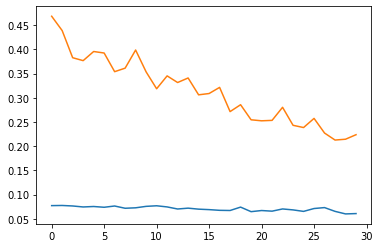

In [40]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])


1/1 [==============================] - 0s 17ms/step


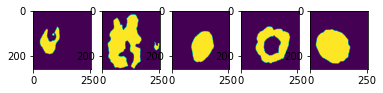

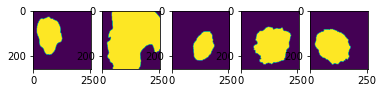

In [41]:
predictions = []
image_mask = []
plots = 5

for i, (img, mask) in enumerate(zip(X_test, y_test)):
    if i == plots:
        break
    img = tf.expand_dims(img, 0)
    pred = np.array(model.predict(img))
    predictions.append(pred[0, :, :, 0] > 0.5)
    image_mask.append(mask)
plotn(plots, (predictions, image_mask))